In [1]:
import os
import pathlib
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import IPython.display
import PIL.Image
import imageio
import cv2

## Input Images Path

In [2]:
# Relative paths to the notebook
images_path = glob.glob("images/*.png")

output_path = 'outputs/'
# If output folder does not exist, create it
p = pathlib.Path(output_path)
if not p.is_dir():
    p.mkdir()

# Execute all dithering functions to all images
# NOTE: THE ENTIRE ACQUISITION TAKES ABOUT 5 MINUTES
execute_acquisitions = True

In [3]:
images_path

['images/objetos1.png', 'images/objetos3.png', 'images/objetos2.png']

In [4]:
images = {}
for img in images_path:
     images[os.path.split(img)[1]] = cv2.imread(img,-1)

## Color Transformation

### Gray

In [5]:
gray_images = {}

for key, img in images.items():
    gray_images[key] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

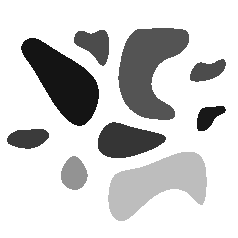

In [6]:
PIL.Image.fromarray(gray_images['objetos3.png'])

### Mono

In [7]:
mono_images = {}

for key, img in gray_images.items():
    mono_images[key] = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]

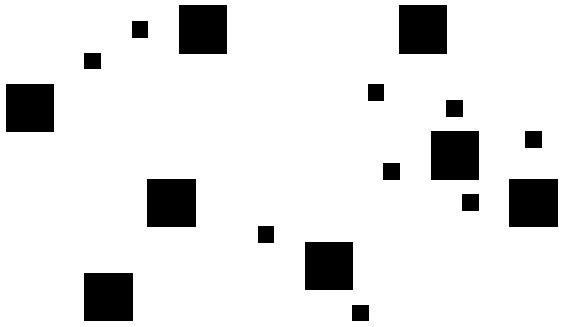

In [8]:
PIL.Image.fromarray(mono_images['objetos1.png'])

## Objects Contours

In [9]:
# In OpenCV, objects are white and the background is black, so we need to invert the image
# before finding the contours
contours = {}

for key, img in mono_images.items():
    # 255 - img is the inverse of img
    contours[key], _ = cv2.findContours(255 - img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [17]:
images_contours = {}

for key, img in mono_images.items():
    images_contours[key] = np.zeros_like(img) + 255
    cv2.drawContours(images_contours[key], contours[key], -1, (0), 2)
    cv2.imwrite(output_path + key[:-4] + "-contour.png", images_contours[key])

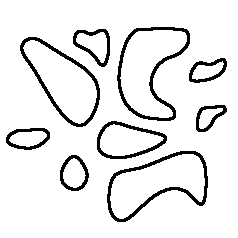

In [11]:
PIL.Image.fromarray(images_contours['objetos3.png'])

## Objects Properties and Area Histogram

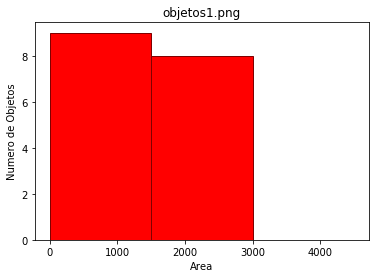

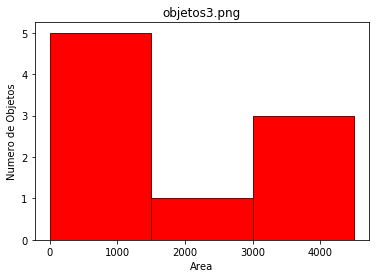

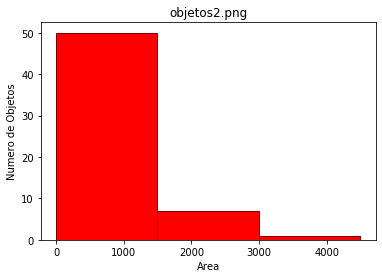

In [25]:
area_histogram = {}

labeled_images = {}

for key, contour_set in contours.items():
    # Histogram Info
    small_area = 0
    medium_area = 0
    big_area = 0

    # Objects properties
    region = 0
    labeled_images[key] = np.clip(np.copy(images[key]) * 1.5, 0, 255).astype(np.uint8)
    
    labeled_images[key][labeled_images[key][:, :] == (255, 255, 255)] = 205
    
    with open(output_path + key[:-4] + "-obj.txt", "w") as f:
        f.write("numero de regioes: " + str(len(contour_set)) + "\n\n")
        
        for obj in contour_set:
            # Area
            area = cv2.contourArea(obj)
            
            if area < 1500:
                small_area += 1
            elif area < 3000:
                medium_area += 1
            else:
                big_area += 1

            # Perimeter
            perimeter = cv2.arcLength(obj, True)
            
            # Eccentricity
            if len(obj) > 4:
                _, (minor_axis, major_axis), _ = cv2.fitEllipse(obj)
                eccentricity = major_axis/minor_axis
            else:
                eccentricity = np.sqrt(2)
            
            # Solidity
            hull = cv2.convexHull(obj)
            hull_area = cv2.contourArea(hull)
            try:
                solidity = float(area)/float(hull_area)
            except ZeroDivisionError:
                continue
            
            # Centroid
            moment = cv2.moments(obj)
            cx = int(moment['m10']/moment['m00'])
            cy = int(moment['m01']/moment['m00'])
            
            color = 255 - labeled_images[key][cy, cx, :]
            color = [int(x) for x in color]
            
            cv2.putText(labeled_images[key],
                        str(region), 
                        (cx - 6, cy + 4), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.45,
                        color,
                        1)
            
            cv2.imwrite(output_path + key[:-4] + "-regions.png", labeled_images[key])
            
            f.write("região " + "{:d}".format(region) + ": área: " + "{:.4f}".format(area) + " perímetro: " +
                    "{:.4f}".format(perimeter) + " excentricidade: " + "{:.4f}".format(eccentricity) +
                    " solidez: " + "{:.4f}".format(solidity) + "\n")
            
            region += 1
        
        # Write histogram info
        f.write("\nnumero de regioes pequenas: " + str(small_area) + "\n")
        f.write("numero de regioes medias: " + str(medium_area) + "\n")
        f.write("numero de regioes grandes: " + str(big_area) + "\n")
        
        # Create histograms
        fig, ax = plt.subplots()
        plt.bar((750, 2250, 3750), (small_area, medium_area, big_area), width=1500, color=[1, 0, 0], edgecolor=[0.5, 0, 0])
        plt.ylabel('Numero de Objetos')
        plt.xlabel('Area')
        plt.title(key)
        plt.savefig(output_path + key[:-4] + "-hist.png")
        plt.show()